In [32]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Étape 1 : Charger les données
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')

# Étape 2 : Encodage des colonnes
le_pollution = LabelEncoder()
le_ligne = LabelEncoder()

# Encode pollution (target)
y_train = le_pollution.fit_transform(train['Niveau de pollution'])

# Encode nom de ligne (feature)
X_train = train[['stop_lon', 'stop_lat', 'Nom de la ligne']].copy()
X_train['Nom de la ligne'] = le_ligne.fit_transform(X_train['Nom de la ligne'])

X_test = test[['stop_lon', 'stop_lat', 'Nom de la ligne']].copy()
X_test['Nom de la ligne'] = le_ligne.transform(X_test['Nom de la ligne'])  # même encodage

# Étape 3 : Entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Étape 4 : Prédiction
y_pred = knn.predict(X_test)
test['Niveau de pollution'] = le_pollution.inverse_transform(y_pred)

# Étape 5 : Fusionner
df_metro_complet = pd.concat([train, test], ignore_index=True)

# Étape 6 : Sauvegarder
df_metro_complet.to_csv('../data/processed/metro_complet.csv', index=False)
print("Fichier metro_complet.csv sauvegardé avec pollution complétée.")


Fichier metro_complet.csv sauvegardé avec pollution complétée.


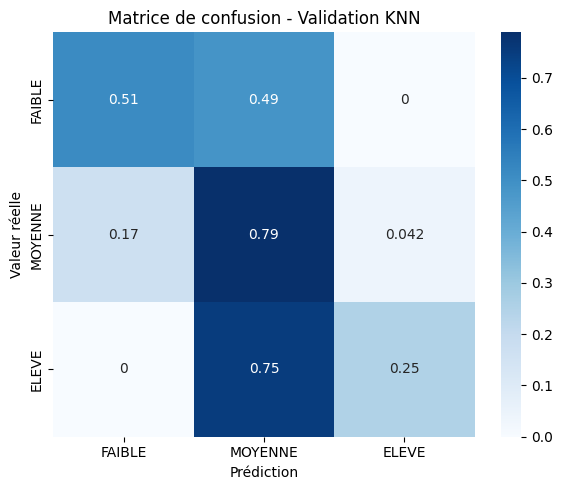

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

# Étape 1 : validation croisée sur les données connues uniquement
X = X_train.copy()
y = y_train.copy()
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_val = KNeighborsClassifier(n_neighbors=3)
knn_val.fit(X_train_split, y_train_split)
y_val_pred = knn_val.predict(X_val)

# Étape 2 : matrice de confusion
labels_order = ['FAIBLE', 'MOYENNE', 'ELEVE']
# Retrouver les indices correspondants dans le LabelEncoder
indices_order = [np.where(le_pollution.classes_ == label)[0][0] for label in labels_order]

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_val_pred, normalize='true')

# Réordonner la matrice
cm_ordered = cm[np.ix_(indices_order, indices_order)]

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ordered, annot=True, cmap='Blues', xticklabels=labels_order, yticklabels=labels_order)
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")
plt.title("Matrice de confusion - Validation KNN")
plt.tight_layout()

# Enregistrement du graphique
plt.savefig("../Data/graph/matrice_confusion_knn.png")

plt.show()


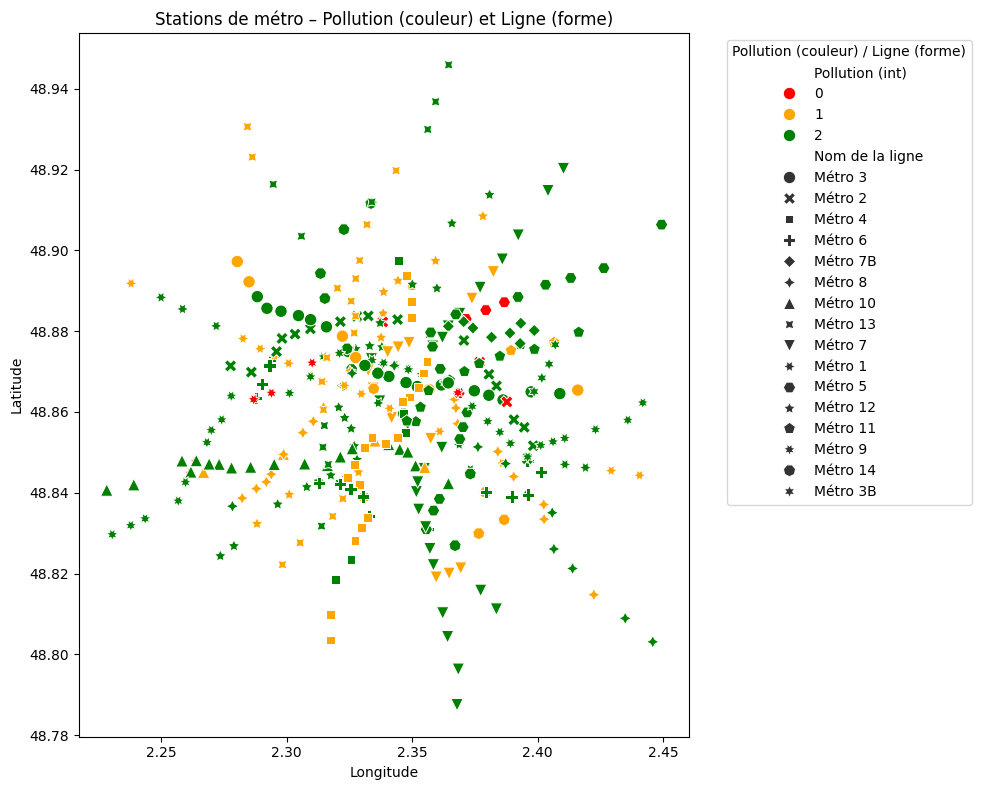

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter une colonne encodée pour les lignes
df = train.copy()
df['Pollution (int)'] = le_pollution.transform(df['Niveau de pollution'])
df['Ligne (int)'] = le_ligne.transform(df['Nom de la ligne'])

# Mise à jour du mapping
pollution_labels = {0: 'ÉLEVÉE', 1: 'MOYENNE', 2: 'FAIBLE'}
palette_pollution = {2:'green', 1: 'orange', 0: 'red'}

# Générer le plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df,
    x='stop_lon',
    y='stop_lat',
    hue='Pollution (int)',
    style='Nom de la ligne',  # forme différente par ligne
    palette=palette_pollution,
    s=80
)
plt.title("Stations de métro – Pollution (couleur) et Ligne (forme)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Pollution (couleur) / Ligne (forme)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Enregistrement du graphique
plt.savefig("../Data/graph/Stations_de_metro_pollutionLigne.png")

plt.show()
